In [ ]:
from pandas_datareader import data as web
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import csv
from matplotlib import pyplot as plt
import random
import plotly.colors
from datetime import datetime
import time
import datetime as dt

In [47]:
def get_data(asset_name='SPY', directory='../../../data/yahoo_data', start_date='01-01-2005', stop_date='12-20-2019', force_yahoo=0):
        
    # If the 'directory' doesn't exist, create it
    if os.path.isdir(directory) == False:
        os.mkdir(directory)

    pathname = directory + '/' + asset_name + '_' + start_date + '.csv'
    if os.path.isfile(pathname) == True and not force_yahoo:
        print('Loading from file: ', pathname)        
        df = pd.read_csv(pathname, index_col='Date')
    else:
        print('Downloading from Yahoo! - ', asset_name)
        df = web.DataReader(asset_name, data_source='yahoo', start=start_date, end=stop_date)
        df.to_csv(pathname)    

    # Copy the (date) index to a Date field and make a new index which enumerates
    # all the entries.
    df.insert(0, 'Date', df.index)
    df.index = np.arange(df.shape[0])
    df['Date']=pd.to_datetime(df['Date'], format='%Y/%m/%d')
    
    return df 

In [48]:
# Synthetic stock generator

# We'll generate the Adj Close price as the primary (since this is the sequnce of labels we are training on)
# The relationship of the other features to the Adj Close will be as follows:
# Close = close_scale * Adj Close
# Open = previous day's Close
# Low = Open
# High = Close
# Volume = 0

# source_asset_name - name of asset to model from
# trend_list - list of tuples - (magnitude, days for a full cycle of this trend)

def make_synthetic_stock(source_asset_name='SPY', new_name='SYN', directory='../../../data/yahoo_data', start_date='01-01-2005', stop_date='12-20-2019', trend_list=[], adj_close_start=0, price_slope=0, close_scale=1.4):
    
    syn_df = get_data(asset_name=source_asset_name, directory=directory, start_date=start_date, stop_date=stop_date, force_yahoo=1)
        
    syn_length = len(syn_df)
    
    for i in range(syn_length):
        mag = adj_close_start + (i * price_slope)
        for trend in trend_list:
            mag += (trend[0] * np.sin(6.28 * i / trend[1]))

        syn_df['Adj Close'].loc[i] = mag
        syn_df['Close'].loc[i] = mag * close_scale
    
        # Today's open is yesterday's close
        if i > 0:
            syn_df['Open'].loc[i] = syn_df['Close'].loc[i-1]
        else:
            syn_df['Open'].loc[i] = syn_df['Close'].loc[i]
        
        syn_df['Low'].loc[i] = syn_df['Open'].loc[i]
        syn_df['High'].loc[i] = syn_df['Close'].loc[i]
    
    pathname = directory + '/' + new_name + '_' + start_date + '.csv'    
    
    syn_df.to_csv(pathname, index=False)    

    

In [4]:
# Display a Plotly interactive candelstick chart

# path is directory to save image in
# display_plot - 1=display plot in Notebook

def plotly_candlestick(asset_df, asset_name, basefn = '', display_plot = 0, save_plot=1):

    df = asset_df
    
    trace1 = {
        'x': df.Date,
        'open': df.Open,
        'close': df.Close,
        'high': df.High,
        'low': df.Low,
        'type': 'candlestick',
        'name': asset_name,
        'showlegend': True
    }

    data = [trace1]
        
    layout = go.Layout({
        'title': {
            'text': 'Asset: ' + asset_name,
            'font': {
                'size': 20
            }
        }
    })

    fig = go.Figure(trace1, layout)
    
    if display_plot:        
        fig.show()
    
    if save_plot:
        fig.write_html(basefn + 'asset_candelstick.html')



In [5]:
def add_features_to_df(df):
    # Add a feature called Prev Adj CLose
    prev_adj_close = df['Adj Close'].shift(1).copy()
    df['Prev Adj Close'] = prev_adj_close

    # Take care of special case of very first previous Adj close - just make is the same as the Adj Close
    df['Prev Adj Close'][0] = df['Prev Adj Close'][1]
    
    # Volume isn't used
    df = df.drop(columns=['Volume'])
    
    return df
    

In [6]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

print("Cuda available:",torch.cuda.is_available())

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Cuda available: True


In [7]:
# This will normalise each column of a dataframe to +/- 0.5

def normalise_df(df):
           
    r = df.copy()
    
    # Get the min and max of all values in dataframe except 'Date' field
    min_value = df.drop('Date',1).min().min()    
    max_value = df.drop('Date',1).max().max()

#    print(min_value)
#    print(max_value)
    
#    r['Open'] = (r['Open'] - min_value) / (max_value - min_value) - 0.5
#    r['Low'] = (r['Low'] - min_value) / (max_value - min_value) - 0.5
#    r['High'] = (r['High'] - min_value) / (max_value - min_value) - 0.5
#    r['Close'] = (r['Close'] - min_value) / (max_value - min_value) - 0.5
#    r['Adj Close'] = (r['Adj Close'] - min_value) / (max_value - min_value) - 0.5
#    r['Prev Adj Close'] = (r['Prev Adj Close'] - min_value) / (max_value - min_value) - 0.5    


    r.loc[:, r.columns != 'Date'] = (((r.loc[:, r.columns != 'Date'] - min_value) / (max_value - min_value)) - 0.5)
#    print(r.describe())
    
#    display(r)
    scale = max_value - min_value
    offset = min_value
#    To un-normalise:
    
#    original_value = ((norm_price + 0.5) * scale) + offset
#    scale = max_value - min_value
#    offset = min_value

#    print("values from df normalisation:")
#    print("Scale:", scale)
#    print("Offset:", offset)


#    display(r.head())
#    display(df.head())
    return r, scale, offset

In [8]:
def denormalise_value(norm_value, scale, offset):
    return (((norm_value + 0.5) * scale) + offset)

In [9]:
def unnormalise_df(df, scale, offset):
    
    result = df.copy()
    
    df = ((df + 0.5) * scale) + offset
    
    return(df)

In [10]:
# This version is for sequence to value learning - the label is a single value - tomorrow's Adj Close

# Given one of the asset train, valid or test dataframes, this will make a new three dimensional list which has
# dimensions (num_samples, window_size - tw, 6) which represents the effect of sliding a window of width window_size (tw)
# down the dataframe from start to end and collecting the input features into a length 6 vector.  This will be our
# input dataset to the LSTM.

# In addition, also generate a list of (training) labels which is "tomorrow's" adjusted closing price - the thing 
# we are trying to predict. There is a single training label for each tw x 6 set of inputs.


def create_input_sequences_out_val_from_df(input_data_df, tw):
    in_seq = []
    out_seq= []
    L = len(input_data_df)

    for i in range(L-tw):
        seq = []
        for j in range(tw):
            features = [input_data_df['Open'].loc[i+j], input_data_df['Low'].loc[i+j], input_data_df['High'].loc[i+j], 
                        input_data_df['Close'].loc[i+j], 
                         input_data_df['Prev Adj Close'].loc[i+j], input_data_df['Adj Close'].loc[i+j]]
            seq.append(features)

        train_label = input_data_df['Adj Close'].loc[i+tw]
        out_seq.append(train_label)
        in_seq.append(seq)
    return in_seq, out_seq


In [11]:
# This version is for sequence to sequence learning - the label is a sequence up to and including tomorrows Adj Close

def create_input_sequences_from_df(input_data_df, tw):
    in_seq = []
    out_seq= []
    L = len(input_data_df)

    for i in range(L-tw):
        window_input_seq = []
        window_output_seq = []
        for j in range(tw):
            features = [input_data_df['Open'].loc[i+j], input_data_df['Low'].loc[i+j], input_data_df['High'].loc[i+j], 
                        input_data_df['Close'].loc[i+j], 
                         input_data_df['Prev Adj Close'].loc[i+j], input_data_df['Adj Close'].loc[i+j]]
            window_input_seq.append(features)
            
            window_output_seq.append(input_data_df['Adj Close'].loc[i+j+1])

        out_seq.append(window_output_seq)
        in_seq.append(window_input_seq)
        
#        print("seq:", i)
#        print("input:\n",window_input_seq)
#        print("output:\n", window_output_seq)
    return in_seq, out_seq


In [12]:
def get_continuous_color(colorscale, intermed):
    """
    Plotly continuous colorscales assign colors to the range [0, 1]. This function computes the intermediate
    color for any value in that range.

    Plotly doesn't make the colorscales directly accessible in a common format.
    Some are ready to use:
    
        colorscale = plotly.colors.PLOTLY_SCALES["Greens"]

    Others are just swatches that need to be constructed into a colorscale:

        viridis_colors, scale = plotly.colors.convert_colors_to_same_type(plotly.colors.sequential.Viridis)
        colorscale = plotly.colors.make_colorscale(viridis_colors, scale=scale)

    :param colorscale: A plotly continuous colorscale defined with RGB string colors.
    :param intermed: value in the range [0, 1]
    :return: color in rgb string format
    :rtype: str
    """
    if len(colorscale) < 1:
        raise ValueError("colorscale must have at least one color")

    if intermed <= 0 or len(colorscale) == 1:
        return colorscale[0][1]
    if intermed >= 1:
        return colorscale[-1][1]

    for cutoff, color in colorscale:
        if intermed >= cutoff:
            low_cutoff, low_color = cutoff, color
        else:
            high_cutoff, high_color = cutoff, color
            break

    # noinspection PyUnboundLocalVariable
    return plotly.colors.find_intermediate_color(
        lowcolor=low_color, highcolor=high_color,
        intermed=((intermed - low_cutoff) / (high_cutoff - low_cutoff)),
        colortype="rgb")

In [13]:
def plotly_gradients(model, min_grads, max_grads, ave_grads, basefn='', display_plot=0, save_plot=1):
    
    scale = plotly.colors.PLOTLY_SCALES["Bluered"]

    print("Number of gradients randomly sampled:", len(ave_grads))  
    
    
    # Assemble the names of the layers
    layers = []
    for n,p in model.named_parameters():
        if (p.requires_grad) and ("bias" not in n):
            layers.append(n)
    
    # Dong this the dumb way just now
    max_array = np.zeros(len(layers))
    min_array = np.ones(len(layers))
    mean_array = np.zeros(len(layers))
    
    for i in range(len(min_grads)):
        for j in range(len(layers)):
            if max_grads[i][j].item() > max_array[j]:
                max_array[j] = max_grads[i][j].item()
            
            mean_array[j] += ave_grads[i][j].item()
            
            if min_grads[i][j].item() < min_array[j]:
                min_array[j] = min_grads[i][j].item()
                   
    mean_array /= len(min_grads)
    
    print(len(layers))
    print(len(min_grads))
    print(len(max_grads))
    print(len(ave_grads))    

    print(min_array)
    print(mean_array)
    print(max_array)
    
    fig = go.Figure()
    df = pd.DataFrame(
#        {'mean': [0.1,0.4,0.5,0.6,0.7,0.8,0.9],
#        'max': [0.3,0.5,0.6,0.9,1.1,1.3,1.6],
#        'min': [0.0,0.2,0.4,0.3,0.5,0.2,0.3],
        {'mean': mean_array,
        'max': max_array,
        'min': min_array,         
        'labels': layers})

    fig.add_trace(go.Scatter(x=df['labels'], y=df['min'],
        fill=None,
        mode='lines',
        line_color=get_continuous_color(scale, 0),
        name="Min",
        line={'width': 4},
        legendgroup="group1"
        ))
    fig.add_trace(go.Scatter(
        x=df['labels'],
        y=df['mean'],
        legendgroup="group2",
        fill='tonexty',
        fillcolor=get_continuous_color(scale, 0.25).replace('rgb','rgba').replace(')',',0.5)'),
        line_color=get_continuous_color(scale, 0.25),
        mode='lines', name="Bottom Half"))
    fig.add_trace(go.Scatter(x=df['labels'], y=df['mean'],
        fill=None,
        mode='lines',
        legendgroup="group1",
        line={'width': 4},
        line_color=get_continuous_color(scale, 0.5),
        name="Mean"))
    fig.add_trace(go.Scatter(
        x=df['labels'],
        y=df['max'],
        legendgroup="group2",
        fill='tonexty',
        fillcolor=get_continuous_color(scale, 0.75).replace('rgb','rgba').replace(')',',0.5)'),
        line_color=get_continuous_color(scale, 0.75),
        mode='lines',
        name="Top Half"))
    fig.add_trace(go.Scatter(x=df['labels'], y=df['max'],
        fill=None,
        mode='lines',
        legendgroup="group1",
        line={'width': 4},
        line_color=get_continuous_color(scale, 1),
        name="Max"
        ))

    if display_plot:
        fig.show()
        
    if save_plot:
        fig.write_html(basefn + 'gradients.html')
    


In [14]:
# train_loss and val_loss are lists containing the loss per step


def plot_losses(train_loss, val_loss, title='Train / Validation Loss', basefn='', display_plot=0, save_plot=1):

    iter = len(train_loss)
    
    # Plot the training / validation loss vs step
    trace1 = {
        'x': np.arange(0,len(train_loss)),
        'y': np.array(train_loss),
                  
        'type': 'scatter',
        'name': 'Training',
        'showlegend': True
    }

    trace2 = {
        'x': np.arange(0,len(val_loss)),
        'y': np.array(val_loss),
                  
        'type': 'scatter',
        'name': 'Validation',
        'showlegend': True
    }

    data = [trace1, trace2]
        
    layout = go.Layout({
        'title': {
            'text': title,
            'font': {
                'size': 20
            }
        }
    })

    fig = go.Figure(data, layout)
    
    if display_plot:
        fig.show()
        
    if save_plot:
        fig.write_html(basefn + 'Train_losses.html')
    



In [15]:
def plot_returns_hist(predicted_returns, actual_returns, title='Histogram: Predicted vs Actual Returns', basefn='', display_plot=0, save_plot=1):

    fig = go.Figure()
    fig.add_trace(go.Histogram(x=predicted_returns, name='Predicted'))
    fig.add_trace(go.Histogram(x=actual_returns, name='Actual'))
    fig.update_layout(
        title_text = title,
        xaxis_title_text = 'Return',
        yaxis_title_text = 'Count'
    )
    
    if display_plot:
        fig.show()
    
    if save_plot:
        fig.write_html(basefn + 'Returns_hist.html')

In [16]:
def plot_hidden(h, basefn='', display_plot=0, save_plot=1):
    
    # h is a tuple containing 2 tensors (one for h, one for c). 
    # Each tensor is of dimension [num layers, batch size, hidden size]
    # e.g. [3, 1, 128]
        
    titles = ['Hidden State', 'Cell State']
    
    x = np.arange(0, h[0].size()[2])
        
    # Loop through hidden and cell states
    for state in range(2):
        data = []
        # Loop through each layer, add a trace for each
        for layer in range(h[state].size()[0]):
            h_tensor = h[state][layer][0].cpu()
            trace = {
                'x': x,                
                'y': np.array(h_tensor.detach().numpy()),
                  
                'type': 'scatter',
                'name': 'Layer '+str(layer),
                'showlegend': True
                }
            data.append(trace)
        
        layout = go.Layout({
            'title': {
                'text': titles[state],
                'font': {
                    'size': 20
                }
            }
        })

        fig = go.Figure(data, layout)
        
        if display_plot:
            fig.show()
        
        if save_plot:
            fig.write_html(basefn + 'Train_hidden_layer_snapshot.html')


In [17]:
def plot_lstm_output(lstm_output, basefn='', display_plot=0, save_plot=1):
    
    # lstm_output is a tuple containing [sequence length] number of tensors.
    # Each tensor is the lstm output with dimensions [batch size, hidden size]
    # e.g. [1, 128]
    
    x = np.arange(0, lstm_output.size()[1])
        
    data = []
    
    # Loop through each layer, add a trace for each
    for i in range(len(lstm_output)):
        lstm_tensor = lstm_output[i].cpu()
        trace = {
            'x': x,
            'y': np.array(lstm_tensor.detach().numpy()),
                  
            'type': 'scatter',
            'name': 'Cell '+str(i),
            'showlegend': True
            }
        data.append(trace)
        
    layout = go.Layout({
        'title': {
            'text': 'LSTM Output',
            'font': {
                'size': 20
            }
        }
    })

    fig = go.Figure(data, layout)
    
    if display_plot:
        fig.show()   
        
    if save_plot:
        fig.write_html(basefn + 'Train_LSTM_output_snapshot.html')
    

In [18]:
def plot_weights(model, basefn='', display_plot=0, save_plot=1):
    
    # Plot the linear weights - just a simple line chart
    linear_tensor = model.linear.weight[0].cpu()
    x = np.arange(0, len(model.linear.weight[0]))
    y = np.array(linear_tensor.detach().numpy())
  
    # Plot the training / validation loss vs step
    trace1 = {
        'x': x,
        'y': y,
                  
        'type': 'scatter',
        'name': 'Linear Weights',
        'showlegend': True
    }

    data = [trace1]
        
    layout = go.Layout({
        'title': {
            'text': 'Linear Weights',
            'font': {
                'size': 20
            }
        }
    })

    fig = go.Figure(data, layout)
    
    if display_plot:
        fig.show()
        
    if save_plot:
        fig.write_html(basefn + 'Train_linear_weights.html')
    
    ave_weights = []
    max_weights = []
    layers = []
    for n,p in model.named_parameters():
        if (p.requires_grad) and ("bias" not in n) and ("linear" not in n):
            layers.append(n)
            ave_weights.append(p.abs().mean().item())
            max_weights.append(p.abs().max().item())

    trace1 = {
        'x' : layers,
        'y' : ave_weights,
        'type' : 'bar'
    }    

    data = [trace1]
    layout = go.Layout({
        'title': {
            'text': 'Average of LSTM Weights',
            'font': {
                'size': 20
            }
        }
    })

    fig = go.Figure(data, layout)

    if display_plot:
        fig.show()
        
    if save_plot:
        fig.write_html(basefn + 'Train_ave_lstm_weights.html')
    
    
    trace1 = {
        'x' : layers,
        'y' : max_weights,
        'type' : 'bar'
    }    

    data = [trace1]
    layout = go.Layout({
        'title': {
            'text': 'MAX of LSTM Weights',
            'font': {
                'size': 20
            }
        }
    })

    fig = go.Figure(data, layout)
    
    if display_plot:
        fig.show()
        
    if save_plot:
        fig.write_html(basefn + 'Train_max_lstm_weights.html')
        
    

In [19]:
def gradient_plot(layer_names, grads, color, title, basefn='', display_plot=0, save_plot=1):
       
    for i in range(len(grads)):
        plt.plot(grads[i], alpha=0.3, color=color)
    
    plt.hlines(0, 0, len(grads)+1, linewidth=1, color="k")
    plt.xticks(range(0,len(grads[0]),1), layer_names, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(grads[0]))
    
    plt.xlabel("Layers")
    plt.ylabel("Gradient")
    plt.title(title)
    plt.grid(True)
           
    # This has to go before the plt.show() otherwise it's blank
    if save_plot:
        plt.savefig(basefn + title + '.png', bbox_inches='tight')

    if display_plot:
        plt.show()


In [20]:
def plot_gradients(model, ave_grads, max_grads, basefn='', display_plot=0, save_plot=1):

    print("Number of gradients randomly sampled:", len(ave_grads))    
    
    # Assemble the names of the layers
    layers = []
    for n,p in model.named_parameters():
        if (p.requires_grad) and ("bias" not in n):
            layers.append(n)

    gradient_plot(layers, ave_grads, 'b', 'Gradient Flow - All Layers - Average', basefn=basefn, display_plot=display_plot, save_plot=save_plot)
    gradient_plot(layers, max_grads, 'r', 'Gradient Flow - All Layers - Max', basefn=basefn, display_plot=display_plot, save_plot=save_plot)
        
    ave_grads_lstm = [sublist[:len(layers)-1] for sublist in ave_grads]
    max_grads_lstm = [sublist[:len(layers)-1] for sublist in max_grads]
    layers_lstm = layers[0:len(layers)-1]
    
    gradient_plot(layers_lstm, ave_grads_lstm, 'b', 'Gradient Flow - LSTM Layers - Average', basefn=basefn, display_plot=display_plot, save_plot=save_plot)
    gradient_plot(layers_lstm, max_grads_lstm, 'r', 'Gradient Flow - LSTM Layers - Max', basefn=basefn, display_plot=display_plot, save_plot=save_plot)
 


In [21]:

class NeilLSTM(nn.Module):
    def __init__(self, input_size = 6, window_size = 11, arch = 'LH', hidden_size = 64, output_size = 1, num_layers = 3, dropout=0.5):
        super().__init__()
        
        # Store some stuff we need to know in the forward pass
        self.n_layers = num_layers        
        self.hidden_layer_size = hidden_size
        self.arch = arch

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=False, bias=True, dropout=dropout, bidirectional=False)
                
        # Define the linear layer
        # Perhaps should perform forward on the lstm to explicitly get the size of the 
        # tensor for sequence to one vs sequence to sequence versions.
        
        # The size of the linear layer for LH or AH model
        if arch == 'LH':
            self.linear = nn.Linear(hidden_size, output_size, bias = True)
        elif arch == 'AH':
            self.linear = nn.Linear(hidden_size * window_size, output_size, bias = True)
        
        torch.nn.init.xavier_uniform_(self.linear.weight)
        
        # NEED TO FIX THIS STUPID HARD CODED INIT
        if num_layers >= 1:
            torch.nn.init.xavier_uniform_(self.lstm.weight_hh_l0)
            torch.nn.init.xavier_uniform_(self.lstm.weight_ih_l0)
            
        if num_layers >= 2:
            torch.nn.init.xavier_uniform_(self.lstm.weight_hh_l1)        
            torch.nn.init.xavier_uniform_(self.lstm.weight_ih_l1)                    
        
        if num_layers >= 3:
            torch.nn.init.xavier_uniform_(self.lstm.weight_hh_l2)                        
            torch.nn.init.xavier_uniform_(self.lstm.weight_ih_l2)                        
        
        
    # Forward pass
    # input_seq shape is: (sequence length, num input features) - there's no batch dimension
    def forward(self, input_seq, hidden, verbose=0):

        if verbose:
            print("\n\nlstm input:\n", input_seq)
            print("\n\nlstm input view:\n", input_seq.view( len(input_seq) , 1 , -1))
            print("\n\nlstm hidden input:\n", hidden)
            
        lstm_out, hidden = self.lstm( input_seq.view( len(input_seq) , 1 , -1), hidden)
        
        if verbose:
            print("\n\nlstm_output:\n", lstm_out)
            print("\n\nhidden output:\n", hidden)
                    
        # Feed forward the outputs of the lstm into the linear layer       
        # lstm_out dims are (seq_len, batch, hidden dim)
        # This is converted to (seq_len, hidden_dim) before input to the linear layer        
        # When T=22 and hidden_layer_size=64, the shape of the lstm_out tensor is [22,1,64]    
        # This view reshapes it to [22, 64]
        lstm_out_view = lstm_out.view(len(input_seq), -1)
        
        if verbose:
            print("\n\nlstm_out_view:\n", lstm_out_view)
                                       
        if verbose:
            print("\n\nLinear weights:\n", self.linear.weight)
            print("\n\ninput to fc:\n", lstm_out_view[-1])
        
        # LH - Just present the last hidden state to the linear network            
        if self.arch == 'LH':
            predictions = self.linear(lstm_out_view[-1])
        # AH - flatten and present all to linear network
        elif self.arch == 'AH':
            predictions = self.linear(torch.flatten(lstm_out_view))
        
        if verbose:
            print("\n\npredictions:\n",predictions)
        
        # predictions has dimension: (1, seq_len)        
        return predictions, hidden, lstm_out_view
    
    
    def init_hidden(self, batch_size = 1):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_layer_size).zero_().to(device),
                 weight.new(self.n_layers, batch_size, self.hidden_layer_size).zero_().to(device))
        return(hidden)
        

In [111]:
# Trains the given LSTM model. Also collects validation data (predicting the next day) and collects stats
# for both.  These are used to observe training vs validation but also to construct the first allocation policy.

def train_model(model, train_seq, train_labels, scale=1, offset=1, train_start=0, train_length=1, epochs = 20, iter_per_seq=1, max_iter=1600, lr = 0.001, dr=0.999, wd=0.0, verbosity=0, basefn='',plot=0):
    input_size = 6
    
    # if plot level is 4, plot graphs on screen for every training run
    if plot == 4:
        dump_log_interval = 1
    else:
        dump_log_interval = 10 # otherwise do it every 10
        
    loss_function = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
    my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer = optimizer, gamma = dr)
    
    batch_size = 1  # batch mode isn't used actually but including for future possible use
               
    if verbosity == 1:
        print('Epc\tTrLoss\t\tValLoss\t\tVAdjC\tVPred\tVAct\tVPredRt\tVActRt\tMDA\tMAPE\tMAE\tMSE')                                
    if verbosity == 2:
        print('Iter\tTrLoss\tTrMSE\tPredRt\tActRt\tValLoss\t\tVAdjC\tVPred\tVAct\tVPredRt\tVActRt\tRunMDA')            
                            
    result_list = []
    
    train_losses = []
    val_losses = []
    val_adj_close_price = []
    ave_grads = []
    max_grads = []
    min_grads = []
    
    # If the number of epochs is high, just sample the gradients stochastically to avoid retaining too much
    # data.
    if (epochs * train_length) > 1000:
        sample_grads = 1000.0 / (epochs * train_length)
    else:
        sample_grads = 1.0
            
    iteration = 0
    # How many times through the entire training set
    for i in range(epochs):
        val_pred_rt = []
        val_act_rt = []
        val_pred_price = []
        val_act_price = []        
        running_mda = 0
        # Each sample in the training set
        for j in range(train_start, train_start + train_length):      

            # Reset the learning rate each time for the inner loop
#            optimizer.param_groups[0]['lr'] = lr
            
            t_mse_list = []
            v_mse_list = []
            il_ave_grads = []
            il_max_grads = []
            
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = wd)
            my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer = optimizer, gamma = dr)
            
            if j%dump_log_interval == 0:
                dump_log = 1
            else:
                dump_log = 0
            
            # How many times we train on each sample as we go
            for iter in range(iter_per_seq):
                # Send input / label data to Cuda if available
                inputs = train_seq[j].to(device)
                labels = train_labels[j].to(device)
        
                model.train()
            
                # Initialise hidden states before every training event
                h = model.init_hidden(batch_size)  
                                    
                optimizer.zero_grad()
        
                y_pred, h, lstm_out = model(inputs, h)
            
                if dump_log:
                    tp = y_pred[-1].item()
                    ta = labels[-1].item()
                    t_mse = (tp-ta)**2

                # y_pred and labels are both size T - sequence to sequence loss function
                train_loss = loss_function(y_pred, labels)
            
                # Compute gradients and update the model
                train_loss.backward()
                                
                optimizer.step()
                my_lr_scheduler.step()
                
                # Do an inner loop validation
                if dump_log:
                    inputs = train_seq[j+1].to(device)
                    labels = train_labels[j+1].to(device)
            
                    with torch.no_grad():
                        h = model.init_hidden(batch_size)
                        y_pred, h, lstm_out = model(inputs, h)
                
                        vp = y_pred[-1].item()
                        va = labels[-1].item()
                        v_mse = (vp-va)**2
                
                    # write detailed training log
                    with open(basefn + 'train_inner.csv', 'a', newline='') as myfile:        
                        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
                        wr.writerow([j,iter,train_loss.item(),tp,ta,t_mse,vp,va,v_mse])
                    
                    t_mse_list.append(t_mse)
                    v_mse_list.append(v_mse)

                    # Grab the inner loop grads - only if we're plotting as we go
                    if plot >= 3:                    
                        il_ave_grad = []
                        il_max_grad = []
                        for n,p in model.named_parameters():
                            if (p.requires_grad) and ("bias" not in n):
                                il_ave_grad.append(p.grad.abs().mean())
                                il_max_grad.append(p.grad.abs().max())
                        il_ave_grads.append(il_ave_grad)
                        il_max_grads.append(il_max_grad)
            
            # After the inner loop completes, plot the charts if enabled
            if dump_log and plot >= 3:
                plot_losses(t_mse_list, v_mse_list, title='Train / Validation Loss. Seq:'+str(j), basefn=basefn, display_plot=1, save_plot=0)
                print("last tp:",tp,"\tlast ta:",ta,"\tlast t_mse:",t_mse)
                print("last vp:",vp,"\tlast va:",va,"\tlast v_mse:",v_mse)
            
                plot_gradients(model, il_ave_grads, il_max_grads, basefn=basefn, display_plot=1, save_plot=0)

            # Sample stochastically the last set of gradients for plotting later
            if plot and (random.random() < sample_grads):
                ave_grad=[]
                max_grad=[]
                min_grad=[]
                for n,p in model.named_parameters():
                    if (p.requires_grad) and ("bias" not in n):
                        ave_grad.append(p.grad.abs().mean())
                        max_grad.append(p.grad.abs().max())
                        min_grad.append(p.grad.abs().min())
                ave_grads.append(ave_grad)
                max_grads.append(max_grad)
                min_grads.append(min_grad)
            
            # Compute metrics for the training set            
            training_loss = train_loss.item()  # This is the sequence to sequence training loss                        
            train_adj_close = inputs[-1][-1].item()   # Adj close at t=0
            train_pred = y_pred[-1].item()  # Next day predicted Adj close
            train_truth = labels[-1].item()  # Next day actual Adj close
            train_mse = (train_pred - train_truth)**2   # MSE of just the predicted value vs truth
            train_predicted_return = (denormalise_value(train_pred, scale, offset) / denormalise_value(train_adj_close, scale, offset)) - 1            
            train_actual_return = (denormalise_value(train_truth, scale, offset) / denormalise_value(train_adj_close, scale, offset)) - 1

            # Compute metrics for the validation - validation is how well the network predicts the next sequence
            model.eval()
            
            inputs = train_seq[j+1].to(device)
            labels = train_labels[j+1].to(device)
            
            with torch.no_grad():
                h = model.init_hidden(batch_size)
        
                y_pred, h, lstm_out = model(inputs, h)
                    
                valid_adj_close = inputs[-1][-1].item()                
                valid_pred = y_pred[-1].item()
                valid_truth = labels[-1].item()
                valid_loss = (valid_pred - valid_truth)**2  # Just the mse of the valid predicted value vs truth
            
                valid_predicted_return = (denormalise_value(valid_pred, scale, offset) / denormalise_value(valid_adj_close, scale, offset)) - 1
                valid_actual_return = (denormalise_value(valid_truth, scale, offset) / denormalise_value(valid_adj_close, scale, offset)) - 1

                if (valid_predicted_return * valid_actual_return >= 0):
                    running_mda += 1                

                result_list.append([i,j,iteration, training_loss, train_mse, train_adj_close, train_pred, train_truth, 
                              train_predicted_return, train_actual_return, valid_loss, valid_adj_close, 
                              valid_pred, valid_truth, valid_predicted_return, valid_actual_return, 100.0*running_mda/(j+1)])
                
                
                if (verbosity==2) and (i==epochs-1):
                    print('{:3}'.format(iteration), 
                          '  {:1.1e}'.format(training_loss),
                          '  {:1.1e}'.format(train_mse),
#                          '\t{:2.6f}'.format(train_adj_close), 
#                          '\t{:2.6f}'.format(train_pred), 
#                          '\t{:2.6f}'.format(train_truth),
                          ' {:2.3 f}'.format(100.0*train_predicted_return), 
                          ' {:2.3 f}'.format(100.0*train_actual_return),
                          '  {:1.1e}'.format(valid_loss), 
                          ' {:1.4 f}'.format(valid_adj_close), 
                          ' {:1.4 f}'.format(valid_pred), 
                          ' {:1.4 f}'.format(valid_truth),
                          ' {:2.4 f}'.format(100.0*valid_predicted_return), 
                          ' {:2.4 f}'.format(100.0*valid_actual_return),
                          '  {:2.2f}'.format(100.0*running_mda/(j+1)))
                    
                train_losses.append(training_loss)
                val_losses.append(valid_loss)
                val_pred_rt.append(valid_predicted_return)
                val_act_rt.append(valid_actual_return)
                val_pred_price.append(valid_pred)
                val_act_price.append(valid_truth)
                val_adj_close_price.append(valid_adj_close)
                        
            if iteration >= max_iter:
                break
            else:
                iteration = iteration + 1
                    
        # Output summary stats at end of epoch
        if verbosity==1:            
            metrics_dict = compute_metrics(np.array(val_pred_rt),
                                   np.array(val_act_rt),
                                   np.array(val_pred_price),
                                   np.array(val_act_price))
            
            print('{:3}'.format(i), '\t{:4.5e}'.format(training_loss),
                          '\t{:4.5e}'.format(valid_loss), 
                          '\t{:2.2f}'.format(valid_adj_close), 
                          '\t{:2.2 f}'.format(valid_pred), 
                          '\t{:2.2 f}'.format(valid_truth),
                          '\t{:2.3 f}'.format(100.0*valid_predicted_return), 
                          '\t{:2.3 f}'.format(100.0*valid_actual_return),
                          '\t{:2.3f}'.format(metrics_dict['MDA']), 
                          '\t{:2.3f}'.format(metrics_dict['MAPE']), 
                          '\t{:2.5e}'.format(metrics_dict['MAE']),
                          '\t{:2.5e}'.format(metrics_dict['MSE']))           
        
        if iteration > max_iter:
            break
        
        
    result_dict = {'val_pred_rt':val_pred_rt, 'val_act_rt':val_act_rt, 'val_pred_price':val_pred_price,
                  'val_act_price':val_act_price, 'val_adj_close_price': val_adj_close_price}
    

    plot_gradients(model, ave_grads, max_grads, basefn=basefn, display_plot=plot, save_plot=1)
    plotly_gradients(model, min_grads, max_grads, ave_grads, basefn=basefn, display_plot=plot, save_plot=1)
    plot_hidden(h, basefn=basefn, display_plot=plot, save_plot=1)
    plot_lstm_output(lstm_out, basefn=basefn, display_plot=plot, save_plot=1)
    plot_weights(model, basefn=basefn, display_plot=plot, save_plot=1)
    plot_losses(train_losses, val_losses, title='Model Training: Training Loss vs Validation Loss', basefn=basefn, display_plot=plot, save_plot=1)
    plot_returns_hist(val_pred_rt, val_act_rt, title='Model Training: Predicted vs Actual Returns', basefn=basefn+'both_', display_plot=plot, save_plot=1)
    plot_returns_hist(val_pred_rt, val_pred_rt, title='Model Training: Predicted Returns', basefn=basefn+'pred_', display_plot=plot, save_plot=1)
    plot_returns_hist(val_act_rt, val_act_rt, title='Model Training: Actual Returns', basefn=basefn+'act_', display_plot=plot, save_plot=1)    
            
    return model, result_list, result_dict



In [112]:
# This creates a model instance and trains it on the training set

def create_train_model(df, basefn='', scale=1, offset=1, arch='LH', window_size = 22, epochs=20, iter_per_seq=1, max_iter=1600, num_layers=2, hidden_size=64, dropout=0.5, lr=0.001, dr=1, wd=0.0, verbosity=0, plot=0):

    # Generate training set
#    df = train_asset_dict[asset]

    train_seq, train_labels = create_input_sequences_from_df(df, window_size)

    # Convert our list of lists to Tensors
    train_seq = torch.FloatTensor(train_seq)
    train_labels = torch.FloatTensor(train_labels)
       
    if verbosity>=1:
        print("Building LSTM Model with the following parameters:")
        print("Architecture:", arch)
        print("Num layers:", num_layers)
        print("Hidden size:", hidden_size)
        print("Dropout:", dropout)
        print("Learning Rate:", lr)
        print("LR Decay Rate:", dr)
        print("Weight Decay:", wd)
        print("Window size:", window_size)
        print("Num Epochs:", epochs)
        print("Iterations per seq:", iter_per_seq)
        print("Start training...")
        
    start_time = time.time()
    
    model = NeilLSTM(input_size=6, window_size=window_size, arch=arch, hidden_size=hidden_size, output_size=window_size, num_layers=num_layers, dropout=dropout)
    model.to(device)

    # Stop one short of the end as we use the t+1 for validation during training
    model, result_list, result_dict = train_model(model, train_seq, train_labels, scale=scale, offset=offset, train_start=0, train_length=len(train_seq)-1, epochs=epochs, iter_per_seq=iter_per_seq, max_iter=max_iter, lr=lr, dr=dr, wd=wd, verbosity=verbosity, basefn=basefn, plot=plot)
    
    # Dump the model configuration and results to log file
    with open(basefn + 'train.csv', 'w', newline='') as myfile:
        
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['Norm Scale:', scale])
        wr.writerow(['Norm Offset:', offset])
        wr.writerow(['Arch:', arch])
        wr.writerow(['Window Size:', window_size])
        wr.writerow(['Hidden Size:', hidden_size])
        wr.writerow(['Num Layers:', num_layers])        
        wr.writerow(['Dropout:', dropout])                
        wr.writerow(['Learning Rate:', lr]) 
        wr.writerow(['LR Decay Rate:', dr])
        wr.writerow(['Weight Decay:', wd])        
        wr.writerow(['Num Epochs:', epochs])
        wr.writerow(['Iterations Per Sequence:', iter_per_seq])
        
        wr.writerow(['Epoch','Iter', 'Ttl_Iter','Tr_Loss','Tr_mse','Tr_Adj_Cls','Tr_Pred_Adj_Cls','Tr_Act_Cls','Tr_Pred_Rt','Tr_Act_Rt',
                    'Val_Loss','Val_Adj_Cls','Val_Pred_Adj_Cls','Val_Act_Adj_Cls','Val_Pred_Rt', 'Val_Act_Rt', 'Run_MDA'])
        
        for i in range(len(result_list)):
            wr.writerow(result_list[i])
            
        wr.writerow(['Training Time:', str(dt.timedelta(seconds=(time.time()-start_time)))])
        
    if verbosity >= 1:
        print("Training Time:", str(dt.timedelta(seconds=(time.time()-start_time))))
    
    # Save the model with the unqiue filename
    torch.save(model,basefn + '_train.mdl')
    
    return model, result_dict

In [113]:
# Compute the interim metrics per the paper table 8 - MDA, MAPE, MAE, MSE

# Pass in lists of next day predicted and actual returns, predicted and actual prices
def compute_metrics(pred_rt, act_rt, pred_price, act_price):
    
    len_data = len(pred_rt)

    product = pred_rt * act_rt
    abs_price_diff = np.abs(act_price - pred_price)
    
    MDA = 100 * len(np.where(product > 0)[0]) / len_data
    MAPE = 100 * np.sum(abs_price_diff / np.abs(act_price)) / len_data
    MAE = np.sum(abs_price_diff) / len_data
    MSE = np.sum(abs_price_diff ** 2) / len_data
    
    metrics_dict = {'N':len_data, 'MDA':MDA, 'MAPE': MAPE, 'MAE': MAE, 'MSE':MSE}
    
    return metrics_dict

In [114]:
# Call this routine whenever a new predicted return is generated (each new day)

# inputs:
# D - a list of all the predicted returns, by trading day, to date
# Q - a list of the bin cut-offs
# new_pred_return - the new predicted return from the model
# percentiles - a list of percentiles used to determine the bins (e.g. [0,10,20,30,40,50,60])

# returns:
# D - Updated
# Q - updated

def update_DQ(D, Q, new_pred_return, percentiles):

    # Append the new predicted return to the existing list
    D = np.append(D,new_pred_return)
    
    # If the predicted return is negative, it won't affect the binning calculation
    if new_pred_return <= 0:
        return D, Q
    
    # Percentile the positive returns
    returns = np.array(D)
    Q = np.percentile(returns[returns >= 0], percentiles)
    
    # Q now contains the cutoff values for each bin.  Each bin will contain approximately 10% of the positive
    # returns except the last one which is an amalgamation of 4 bins so it will contain approx 40%
        
    # return updated D and Q
    return D, Q

In [115]:
# Call this routine whenever a new sell is executed (and therefore we have a new expected value for a bin)

def update_EA(E, A, profit, purchase_bin):

    # Append the new profit amount to the correct bin in E        
    E[purchase_bin] = E[purchase_bin] + profit
    
    # Update A - bins with positive total profits are set to 1 (a buy signal)
    # bins with negative profits are set to 0 - a do nothing signal
    # bin 0 is the unique, sell signal
    A = (E > 0).astype(int)    
    
    return E, A

    

In [116]:
# This function combines model training (updates), predicting next day return, trading and updating the trading
# policy each day.
# Much of the code is a repeat / combo of the above two seperate routines of training the model and 
# genertaing the policy. This is different as we are now "live" and updating the model / policy only on
# previously unseen data.
# Also, although the model is using Adj Close as the label for training, what we need to record for evaluation
# is the Open price for purchases and sales (assuming we are running the model overnight between two trade
# days).The model updates and issues trades which will be filled at the next trading day open.


def test_trading_system(model, test_seq, test_labels, D, Q, E, A, percentiles, basefn='', scale=1, offset=1, iter_per_seq=1, lr = 0.001, dr = 1, verbosity=0):
    input_size = 6
        
    loss_function = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer = optimizer, gamma = dr)
    
    batch_size = 1  # batch mode isn't used actually but including for future possible use
            
    holding = False;
    journal = []   
    total_profit_open = 0
    total_profit_adj_close = 0
    C = np.zeros(shape=(len(E)))
    
    # Keep list of predicted and actual returns and prices (for metrics reporting)
    test_pred_rt = []
    test_act_rt = []
    test_pred_price = []
    test_act_price = []    
    
    start_time = time.time()
    
    trades_fn = basefn + '_trades.csv'
    losses_fn = basefn + '_losses.csv'
    
    # Write headings for trades file
    with open(trades_fn, 'w', newline='') as myfile:    
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['Day','Adj Close','Pred Rt', 'Act Rt','Buy/Sell','Adj Cls Sell Price','Open Sell Price',
                     'Bin','AdjCls Profit','Open Profit','Acc Profit Adj Cls','Acc Profit Open',
                     'E0','E1','E2','E3','E4','E5','E6','E7',
                     'A0','A1','A2','A3','A4','A5','A6','A7',                     
                     'C0','C1','C2','C3','C4','C5','C6','C7',
                     'Q0','Q1','Q2','Q3','Q4','Q5','Q6'])

    # Write headings for losses file
    with open(losses_fn, 'w', newline='') as myfile:    
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        heading_list=['Day','Trainloss','TestPred', 'TestAct', 'TestPredRt', 'TestActRt', 'TestLoss']
        for i in range(len(test_seq[0])):
            heading_list.append('TP'+str(i))
        for i in range(len(test_seq[0])):
            heading_list.append('TL'+str(i))            
        for i in range(len(test_seq[0])):
            heading_list.append('VP'+str(i))            
        for i in range(len(test_seq[0])):
            heading_list.append('VL'+str(i))                        
        wr.writerow(heading_list)
        
    total_profit = 0
    num_trades = 0
    
    for j in range(0, len(test_seq) - 2):      

        # Send input / label data to Cuda if available
        train_inputs = test_seq[j].to(device)
        train_labels = test_labels[j].to(device)
        
        model.train()

        test_log = []
        
        # How many times we train on each sample as we go
        for iter in range(iter_per_seq):

            # Initialise hidden states before every epoch
            h = model.init_hidden(batch_size)  
                                    
            optimizer.zero_grad()
        
            train_y_pred, h, lstm_out = model(train_inputs, h, verbose=0)
               
    #        test_loss = loss_function(y_pred[-1], labels)
            train_test_loss = loss_function(train_y_pred, train_labels)
               
            # Compute gradients and update the model
            train_test_loss.backward()
            optimizer.step()
            my_lr_scheduler.step()
                       
        # Having updated the model with "todays" inputs, we now predict "tomorrows" return
        model.eval()
            
        inputs = test_seq[j+1].to(device)
        labels = test_labels[j+1].to(device)
            
        with torch.no_grad():
            h = model.init_hidden(batch_size)
        
            y_pred, h, lstm_out = model(inputs, h)
            test_adj_close = inputs[-1][-1].item()                
            test_pred = y_pred[-1].item()
                        
            test_predicted_return = (denormalise_value(test_pred, scale, offset) / denormalise_value(test_adj_close, scale, offset)) - 1
            test_truth = labels[-1].item()
            test_actual_return = (denormalise_value(test_truth, scale, offset) / denormalise_value(test_adj_close, scale, offset)) - 1            

            test_pred_price.append(test_pred)
            test_act_price.append(test_truth)            
            test_loss = (test_pred - test_truth)**2
            
            test_pred_rt.append(test_predicted_return)
            test_act_rt.append(test_actual_return)
            
        if verbosity >= 3:
            print(j, '{:1.2f}'.format(test_adj_close), '{:1.4f}'.format(test_predicted_return))
            
        test_log = [j, test_adj_close, test_predicted_return, test_actual_return]
            
        # Sell if return is negative or if it's the last day of trading and we're holding the asset
        if ((test_predicted_return < 0 or j == len(test_seq) - 3)) and holding:
            open_sell_price = denormalise_value(test_seq[j+2][-1][0].item(), scale, offset) # Next day open
            sell_price = denormalise_value(test_adj_close, scale, offset)
            profit = sell_price - purchase_price
            total_profit += profit
            num_trades += 1
            E, A = update_EA(E, A, profit, purchase_bin)
            if verbosity >= 3:
                print("E", E)
                print("A", A)
            holding = False
            
            total_profit_open = total_profit_open + (open_sell_price - open_purchase_price)
            total_profit_adj_close = total_profit_adj_close + profit
            journal.append((-1, j+2+len(inputs), sell_price, total_profit_adj_close, open_sell_price, total_profit_open))
            
            if verbosity >= 2:
                print("Executed sell at ${:1.2f}".format(sell_price), "on day", j, "Profit: ${:1.4f}".format(profit),
                     "Total Profit: ${:1.4f}".format(total_profit))
                
            test_log += (['Sell', sell_price, open_sell_price, purchase_bin, profit, open_sell_price - open_purchase_price, 
                          total_profit_adj_close, total_profit_open] + E.tolist() + A.tolist() + C.tolist() + Q.tolist())

        # Buy
        if test_predicted_return >= 0 and not holding:
            return_bin = np.digitize(test_predicted_return, Q)
            if verbosity >= 3:
                print("Q",Q,"return_bin", return_bin)
            if A[return_bin] > 0:
                purchase_bin = return_bin
                C[purchase_bin] = C[purchase_bin] + 1
                num_trades += 1
                open_purchase_price = denormalise_value(test_seq[j+2][-1][0].item(), scale, offset) # Next day open
                purchase_price = denormalise_value(test_adj_close, scale, offset)
                holding = True
                journal.append((1, j+2+len(inputs), purchase_price, total_profit_adj_close, open_purchase_price, total_profit_open))
                
                if verbosity >= 2:
                    print("Executed buy at ${:1.2f}".format(purchase_price), "on day ", j, "bin", return_bin)
                    
                test_log += (['Buy', purchase_price, open_purchase_price, purchase_bin, 'N/A', 'N/A', 
                              total_profit_adj_close, total_profit_open] + E.tolist() + A.tolist() + C.tolist() + Q.tolist())

        D, Q = update_DQ(D, Q, test_predicted_return, percentiles)
        
        # Append the metrics to the training log file
        with open(trades_fn, 'a', newline='') as myfile:    
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerow(test_log)
            
        # Make a record of the training / test losses
        with open(losses_fn, 'a', newline='') as losses_file:
            wr = csv.writer(losses_file, quoting=csv.QUOTE_ALL)
            wr.writerow([j,train_test_loss.item(),test_pred, test_truth, 
                         test_predicted_return, test_actual_return, test_loss] 
                        + train_y_pred.tolist() + train_labels.tolist() + y_pred.tolist() + labels.tolist())
        

    # Item 0 is the Open price
    start_price = denormalise_value(test_seq[0][-1][0].item(), scale, offset)

    # Item 3 is the Close price
    end_price = denormalise_value(test_seq[-1][-1][3].item(), scale, offset)

    if len(journal):
        test_profit = journal[-1][-1]
        test_return_pct = 100 * journal[-1][-1]/start_price
    else:
        test_profit = 0
        test_return_pct = 0
    
    if verbosity >= 1:

        print("Buy and Hold Baseline:")
        print("Price at start: ${:1.2f}".format(start_price))
        print("Price at end: ${:1.2f}".format(end_price))
        print("Difference: ${:1.2f}".format(end_price - start_price))
        print("Return:{:1.2f}%".format(100*(end_price - start_price)/start_price))

        print("\nProfit from trading:{:1.2f}".format(test_profit))
        print("Return from trading:{:1.2f}%".format(test_return_pct))
        print("Num trades:{:3}".format(num_trades))
    
        print("Length Returns:", len(D))
        print("Q:\n", Q)
        print("E:\n", E)
        print("A:\n", A)
        print("C:\n", C)
        
        print("Test Time:", str(dt.timedelta(seconds=(time.time()-start_time))))
        
    metrics_dict = compute_metrics(np.array(test_pred_rt),
                                   np.array(test_act_rt),
                                   np.array(test_pred_price),
                                   np.array(test_act_price))

    if verbosity >= 1:
        print("N:", metrics_dict['N'], "\tMDA:{:1.2f}".format(metrics_dict['MDA']), "\tMAPE:{:1.2f}".format(metrics_dict['MAPE']), 
              "\tMAE:{:1.5e}".format(metrics_dict['MAE']), "\tMSE:{:1.5e}".format(metrics_dict['MSE']))        
        
    result_dict = {'bnh_profit': end_price - start_price, 'bnh_Return':100*(end_price - start_price)/start_price,
              'trade_profit':test_profit, 'trade_return': test_return_pct, 'pred_rt':test_pred_rt, 
                  'act_rt':test_act_rt, 'pred_price':test_pred_price, 'act_price':test_act_price}

    # Append the metrics to the training log file
    with open(trades_fn, 'a', newline='') as myfile:    
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['Num Samples For Metrics:', metrics_dict['N']])
        wr.writerow(['MDA:', metrics_dict['MDA']])
        wr.writerow(['MAPE:', metrics_dict['MAPE']])
        wr.writerow(['MAE:', metrics_dict['MAE']])
        wr.writerow(['MSE:', metrics_dict['MSE']])
        
        wr.writerow(['Open Start Price:', start_price])        
        wr.writerow(['Open End Price:', end_price])
        wr.writerow(['Difference (Open to Open) $:', end_price-start_price])
        wr.writerow(['Open Buy and Hold Return %:', 100*(end_price - start_price)/start_price])        
        
        wr.writerow(['Total profits from trading $:', test_profit])        
        wr.writerow(['Return from trading %:', test_return_pct])
        wr.writerow(['Total trades:', num_trades])
        
        wr.writerow(['Total Test Time:', str(dt.timedelta(seconds=(time.time()-start_time)))])
        
    
    result_dict.update(metrics_dict)

            
    # return updated model, updated D, Q E and A, journal and results from this test period
    return model, D, Q, E, A, journal, result_dict

In [117]:
def run_hypers(window_size=11, asset='SPY', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.01, dr=1.0, wd=0.0, run_out_of_sample_test=0, verbosity=0, plot=0):
    
    basefn = datetime.today().strftime('%Y-%m-%d-%H-%M-%S' + '/') 
    
    # Make a results directory. If the 'directory' doesn't exist, create it
    if os.path.isdir(basefn) == False:
        os.mkdir(basefn)

    
    # Go get the data for the asset
    abs_df = get_data(asset_name=asset, directory='../../../data/yahoo_data', start_date='01-01-2005', stop_date='12-20-2019')    

    plotly_candlestick(abs_df, asset, basefn=basefn, display_plot=plot, save_plot=1)
    
    # Add the Prev Adj Close, drop volume etc
    abs_df = add_features_to_df(abs_df)
    
    # Normalise the entire dataset
    df, scale, offset = normalise_df(abs_df)
    
    plotly_candlestick(df, asset, basefn=basefn, display_plot=plot, save_plot=1)    
                
    # Training set
    train_start = '01-01-2005'
    train_end = '01-01-2008'    

    # Validation set
    valid_start = '01-02-2008'
    valid_end = '12-31-2009'    
    
    # Out of sample test set
    test_start = '01-01-2010'
    test_end = '12-20-2019'
    
    train_asset_dict = {}
    valid_asset_dict = {}
    test_asset_dict = {}    
    
    # Mask off the training data and assign result to a train_asset dataframe
    mask = (df['Date'] >= train_start) & (df['Date'] <= train_end)
    train_asset_df = df.loc[mask]
    
    backup_index = len(train_asset_df) - window_size
    backup_date = df['Date'].iloc[backup_index]
    
    # Mask off the validation data and assign result to a valid_asset dataframe
#    mask = (df['Date'] >= valid_start) & (df['Date'] <= valid_end)
    mask = (df['Date'] >= backup_date) & (df['Date'] <= valid_end)
    valid_asset_df = df.loc[mask]
    
    # Mask off the test data and assign result to a test_asset dataframe
    mask = (df['Date'] >= test_start) & (df['Date'] <= test_end)
    test_asset_df = df.loc[mask]
        
    # Reset the indices to start from 0 again for each of the dataframes
    train_asset_df.index = np.arange(train_asset_df.shape[0])   
    valid_asset_df.index = np.arange(valid_asset_df.shape[0])    
    test_asset_df.index = np.arange(test_asset_df.shape[0]) 
        
    percentiles = [0,10,20,30,40,50,60]
       
    model, train_result_dict = create_train_model(train_asset_df, basefn=basefn, scale=scale, offset=offset, arch=arch, 
                                            window_size = window_size, epochs=train_epochs,
                                            iter_per_seq=iter_per_seq, max_iter=1E32, num_layers=num_layers,
                                            hidden_size=hidden_size, dropout=dropout, lr=lr, dr=dr, wd=wd,
                                            verbosity=verbosity, plot=plot)
        
    
    # These start and stop idx's mark the safe area of the training validation results (avoiding discontinuities)    
    # No longer needed now we are not wrapping back around doing epoch training
    stop_idx = len(train_result_dict['val_pred_rt'])
#    start_idx = stop_idx - len(train_asset_df) + 100
    start_idx = 0

    metrics_dict = compute_metrics(np.array(train_result_dict['val_pred_rt'])[start_idx:stop_idx],
                                   np.array(train_result_dict['val_act_rt'])[start_idx:stop_idx],
                                   np.array(train_result_dict['val_pred_price'])[start_idx:stop_idx],
                                   np.array(train_result_dict['val_act_price'])[start_idx:stop_idx])

    if verbosity >= 1:
        print("N:", metrics_dict['N'], "\tMDA:{:1.2f}".format(metrics_dict['MDA']), "\tMAPE:{:1.2f}".format(metrics_dict['MAPE']), 
              "\tMAE:{:1.5e}".format(metrics_dict['MAE']), "\tMSE:{:1.5e}".format(metrics_dict['MSE']))    

    # Append the metrics to the training log file
    with open(basefn + 'train.csv', 'a', newline='') as myfile:    
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['Num Samples For Metrics:', metrics_dict['N']])
        wr.writerow(['MDA:', metrics_dict['MDA']])
        wr.writerow(['MAPE:', metrics_dict['MAPE']])
        wr.writerow(['MAE:', metrics_dict['MAE']])
        wr.writerow(['MSE:', metrics_dict['MSE']])
    
    
    # MODEL TRAINING COMPLETE - NOW WE BUILD THE INITIAL ALLOCATION POLICY
    
    # Point D at the training predicted returns - for the period we are interested in (last epoch, avoiding discontinuity)
    D = np.array(train_result_dict['val_pred_rt'])[start_idx:stop_idx]

    # Compute the percentiles of only the POSITIVE training returns
    Q = np.percentile(D[D >= 0], percentiles)
    
    if verbosity >= 1:
        print("Num expected returns from training:", len(D))
        print("Initial Q:\n",Q)

    # There will be 8 bins from 7 percentiles - anything below the lowest percentile is placed in bin 0
    # Anything equal to or greater than the lowest percentile but less than the 2nd wil be in bin 1 etc
    # Anything equal to or greater than the last percentile will be in the last bin.
    
    if verbosity >= 2:
        binned_returns = np.digitize(D, Q)
        unique, counts = np.unique(binned_returns, return_counts=True)
        print("Unique bins:", unique)
        print("Counts / bin:", counts)

    # Generate the Expected Returns for each bin in Q from the training data
    
    holding = False
    E = np.zeros(shape=(len(percentiles)+1))
    C = np.zeros(shape=(len(percentiles)+1))
    
    if verbosity >= 1:
        print("\nComputing initial allocation policy from the training set...")
    
    pred_rt = np.array(train_result_dict['val_pred_rt'])
    act_rt = np.array(train_result_dict['val_act_rt'])
    adj_close = np.array(train_result_dict['val_adj_close_price'])
    
    with open(basefn + '_init_alloc.csv', 'w', newline='') as myfile:    
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(['Day','Adj Close','Pred Rt', 'Act Rt','Buy/Sell','Sell Price','Bin','Acc Profit','Total Profit',
                     'E0','E1','E2','E3','E4','E5','E6','E7',
                     'C0','C1','C2','C3','C4','C5','C6','C7',
                     'D0','D1','D2','D3','D4','D5','D6'])
        
    total_profit = 0

    # Walk through the returns in the known valid region of the end of the training data
    for i in range(start_idx, stop_idx):
    
        init_alloc_results = []
        
        if verbosity >= 2:
            print(i, '{:1.2f}'.format(adj_close[i]), '{:1.4f}'.format(pred_rt[i]))
        
        init_alloc_results=[i,adj_close[i],pred_rt[i], act_rt[i]]
        
        # Sell
        if pred_rt[i] < 0 and holding:
            sell_price = denormalise_value(adj_close[i], scale, offset)
            profit = sell_price - purchase_price
            total_profit += profit
            E[purchase_bin] = E[purchase_bin] + profit
            holding = False
            if verbosity >= 2:
                print("Executed sell at ${:1.2f}".format(sell_price), "on day", i, "Profit: ${:1.4f}".format(profit))
            init_alloc_results += (['Sell', sell_price, purchase_bin, profit, total_profit] + E.tolist() + C.tolist() + Q.tolist())

        # Buy
        if pred_rt[i] >= 0 and not holding:
            return_bin = np.digitize(pred_rt[i], Q)
            purchase_bin = return_bin
            C[purchase_bin] = C[purchase_bin] + 1
            purchase_price = denormalise_value(adj_close[i], scale, offset)
            holding = True
            if verbosity >= 2:
                print("Executed buy at ${:1.2f}".format(purchase_price), "on day ", i, "bin", return_bin)
            init_alloc_results += (['Buy', purchase_price, purchase_bin, 'N/A', total_profit] + E.tolist() + C.tolist() + Q.tolist())
            
        # Append the metrics to the training log file
        with open(basefn + '_init_alloc.csv', 'a', newline='') as myfile:    
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerow(init_alloc_results)

    
    # It's important to understand that bin 0 won't have any trades at this point because we gave it the training
    # data with a certain lower positive return. This value defines the lowest cut off of the training data. However,
    # once we start getting new data we will see values probaby lower than this lowest bin cut off.
    
    A = (E > 0).astype(int)
    
    with open(basefn + '_init_alloc.csv', 'a', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow([' ','A0','A1','A2','A3','A4','A5','A6','A7'])
        wr.writerow(['Initial Allocation Policy:'] + A.tolist())
        
    if verbosity >= 1:
        print("Expected Gains per Bin:", E)
        print("Trades per bin:", C)
        print("\nInitial Allocation Policy:",A)    
                
        print("\nPERFORMING VALIDATION...")
        
    # Generate validation attribute set
    valid_seq, valid_labels = create_input_sequences_from_df(valid_asset_df, window_size)


    # Convert our list of lists to Tensors
    valid_seq = torch.FloatTensor(valid_seq)
    valid_labels = torch.FloatTensor(valid_labels)

    model, D, Q, E, A, journal, test_result_dict = test_trading_system(model, valid_seq, valid_labels, D, Q, E, A, percentiles, basefn=basefn+'_val', scale=scale, offset=offset, iter_per_seq=iter_per_seq, lr = 0.001, dr = 1, verbosity=verbosity)

    result_dict = {'val_profit':test_result_dict['trade_profit'], 'val_return_pct':test_result_dict['trade_return']}
            
                
    if run_out_of_sample_test:
        
        if verbosity >= 1:
            print("\nEVALUATING TEST SET...")    
    
        # Generate test attribute set
        test_seq, test_labels = create_input_sequences_from_df(test_asset_df, window_size)

        # Convert our list of lists to Tensors
        test_seq = torch.FloatTensor(test_seq)
        test_labels = torch.FloatTensor(test_labels)

        model, D, Q, E, A, journal, test_result_dict = test_trading_system(model, test_seq, test_labels, D, Q, E, A, percentiles, basefn=basefn+'test', scale=scale, offset=offset, iter_per_seq=iter_per_seq, lr = 0.001, dr = 1, verbosity=verbosity)
    
        result_dict['test_profit'] = test_result_dict['trade_profit']
        result_dict['test_return_pct'] = test_result_dict['trade_return']
    
    return model, journal, result_dict
    


In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.00001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.000001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.000001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.000001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.000001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.000001, dr=1, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.99, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.99, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.99, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.99, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.99, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.9, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.9, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.9, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.9, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.9, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.91, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.92, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.93, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.94, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.95, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.96, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.97, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.98, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=0.99, wd=0, run_out_of_sample_test=0, verbosity=1, plot=1)

In [ ]:
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=0.999, wd=0, run_out_of_sample_test=0, verbosity=2, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=0.999, wd=1E-8, run_out_of_sample_test=0, verbosity=2, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=0.999, wd=1E-7, run_out_of_sample_test=0, verbosity=2, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=0.999, wd=1E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=0.999, wd=1E-5, run_out_of_sample_test=0, verbosity=2, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=0.999, wd=1E-4, run_out_of_sample_test=0, verbosity=2, plot=1)
model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=0.999, wd=1E-3, run_out_of_sample_test=0, verbosity=2, plot=1)


In [ ]:
# r1 - r8 run on 16/2/21-18/2/21
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
    model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.0001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.0001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)
    model, journal, result = run_hypers(window_size=11, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.0001, dr=1, wd=5E-6, run_out_of_sample_test=0, verbosity=2, plot=1)

In [ ]:
# make_synthetic_stock(source_asset_name='SPY', new_name='SYN', directory='../../../data/yahoo_data', start_date='01-01-2005', stop_date='12-20-2019', trend_list=[(10,37),(7,17),(3,7)], adj_close_start=85, price_slope=0, close_scale=1)

In [44]:
make_synthetic_stock(source_asset_name='SPY', new_name='SYN2', directory='../../../data/yahoo_data', start_date='01-01-2005', stop_date='12-20-2019', trend_list=[(10,33),(5,17)], adj_close_start=85, price_slope=0, close_scale=1)

Loading from file:  ../../../data/yahoo_data/SPY_01-01-2005.csv


C:\Users\q2\Anaconda3\envs\mlp\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
make_synthetic_stock(source_asset_name='SPY', new_name='SYN3', directory='../../../data/yahoo_data', start_date='01-01-2005', stop_date='12-20-2019', trend_list=[(10,33),(5,17)], adj_close_start=85, price_slope=0.01, close_scale=1)

Loading from file:  ../../../data/yahoo_data/SPY_01-01-2005.csv


C:\Users\q2\Anaconda3\envs\mlp\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [37]:
make_synthetic_stock(source_asset_name='SPY', new_name='SYN4', directory='../../../data/yahoo_data', start_date='01-01-2005', stop_date='12-20-2019', trend_list=[(10,33),(5,17),(3,11),(2,3)], adj_close_start=85, price_slope=0.01, close_scale=1)

Loading from file:  ../../../data/yahoo_data/SPY_01-01-2005.csv


In [49]:
make_synthetic_stock(source_asset_name='SPY', new_name='SYN4S', directory='../../../data/yahoo_data', start_date='01-01-2005', stop_date='03-31-2005', trend_list=[(10,33),(5,17),(3,11),(2,3)], adj_close_start=85, price_slope=0.01, close_scale=1)

C:\Users\q2\Anaconda3\envs\mlp\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
iterations_win_leg()
epochs_win_leg()
iterations_lr_leg()



In [68]:
# SPY Num Iterations Leg - using optimum settings from SYN4 experiments
def spy_iterations_leg():
    %mkdir "num_iter"
    %cd num_iter
    
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=50, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=200, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=300, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=400, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    %cd ..
    

In [70]:
# SPY Num Iterations Leg - using optimum settings from SYN4 experiments
def spy_iterations_leg2():
    %mkdir "num_iter2"
    %cd num_iter
    
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1100, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1200, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1300, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1400, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=1500, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
#    model, journal, result = run_hypers(window_size=44, asset='SPY', train_epochs=1, iter_per_seq=400, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    %cd ..

In [ ]:
spy_iterations_leg2()

In [66]:
# Num Iterations Leg - using optimum settings from SYN4 experiments
def iterations_leg():
    %mkdir "num_iter"
    %cd num_iter
    
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=5, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=20, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=40, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=80, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    %cd ..
    

In [ ]:
iterations_leg()

In [ ]:
# Iterations, Window size leg
def iterations_win_leg():
    %mkdir "iter_win_len"
    %cd iter_win_len
    model, journal, result = run_hypers(window_size=1, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=2, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=3, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=7, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=11, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=88, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    %cd ..


In [31]:
# Epochs, Window size leg
def epochs_win_leg():
    %mkdir "epoch_win_len"
    %cd epoch_win_len

    model, journal, result = run_hypers(window_size=1, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=2, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=3, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=7, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=11, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=44, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=88, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)

    %cd ..

In [32]:
# Iterations, Learning rate leg
def iterations_lr_leg():
    %mkdir "iter_lr"
    %cd iter_lr
    
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.000001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.00001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.01, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.1, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)

    %cd ..

In [33]:
# Epoch, Learning rate leg
def epoch_lr_leg():
    %mkdir "epoch_lr"
    %cd epoch_lr
    
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.000001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.00001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.0001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.01, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.1, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    
    %cd ..


In [34]:
# Iterations, Hidden size leg
def iterations_hidden_size_leg():
    %mkdir "iter_hidden_len"
    %cd iter_hidden_len
    
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=2, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=4, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=8, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=16, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=32, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=1, iter_per_seq=10, arch='LH', num_layers=3, hidden_size=256, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    
    %cd ..

In [35]:
# Epochs, Hidden size leg
def epochs_hidden_size_leg():
    %mkdir "epoch_hidden_len"
    %cd epoch_hidden_len
    
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=2, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=4, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=8, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=16, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=32, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=64, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=128, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    model, journal, result = run_hypers(window_size=22, asset='SYN4', train_epochs=10, iter_per_seq=1, arch='LH', num_layers=3, hidden_size=256, dropout=0.5, lr=0.001, dr=1, run_out_of_sample_test=0, verbosity=1, plot=1)
    
    %cd ..

In [ ]:
# Everything past here is graveyard / experimental

In [ ]:
test_results = []
val_results = []
for i in range(10):
    print("\nTrial:", i)
    print("********\n")
    model, journal, result = run_hypers(verbosity = 1, plot = 1)
    test_results.append(result['test_return_pct'])
    val_results.append(result['val_return_pct'])
    
print(np.mean(np.array(val_results)))
print(np.std(np.array(val_results)))

print(np.mean(np.array(test_results)))
print(np.std(np.array(test_results)))

In [ ]:
torch.set_printoptions(profile="short")

for name in model.named_parameters():
    print(name[0])
    print(name[1][:])

print(model.lstm.weight_ih_l0.size())
print(model.lstm.bias_ih_l0.size())
print(model.lstm.weight_hh_l0.size())
print(model.lstm.bias_hh_l0.size())


print(model.lstm.weight_hh_l1.size())
print(model.lstm.weight_ih_l1.size())

print(model.lstm.weight_hh_l2.size())
print(model.lstm.weight_ih_l2.size())

print(model.linear.weight.size())
print(model.linear.bias.size())





In [ ]:
# Use first asset in list of assets as the source
assets = ['SPY', 'DIA', 'ONEQ', 'IWM']

print(asset_list)
syn_df = asset_dict[asset_list[0]].copy()

display(syn_df.head(5))
print(syn_df.describe())    

asset_dict['SYN'] = syn_df 

trend_list = [(1, 20)]
make_synthetic_df(asset_dict['SYN'], trend_list, 0, 0, 1.4)

display(syn_df.head(5))
print(syn_df.describe())    


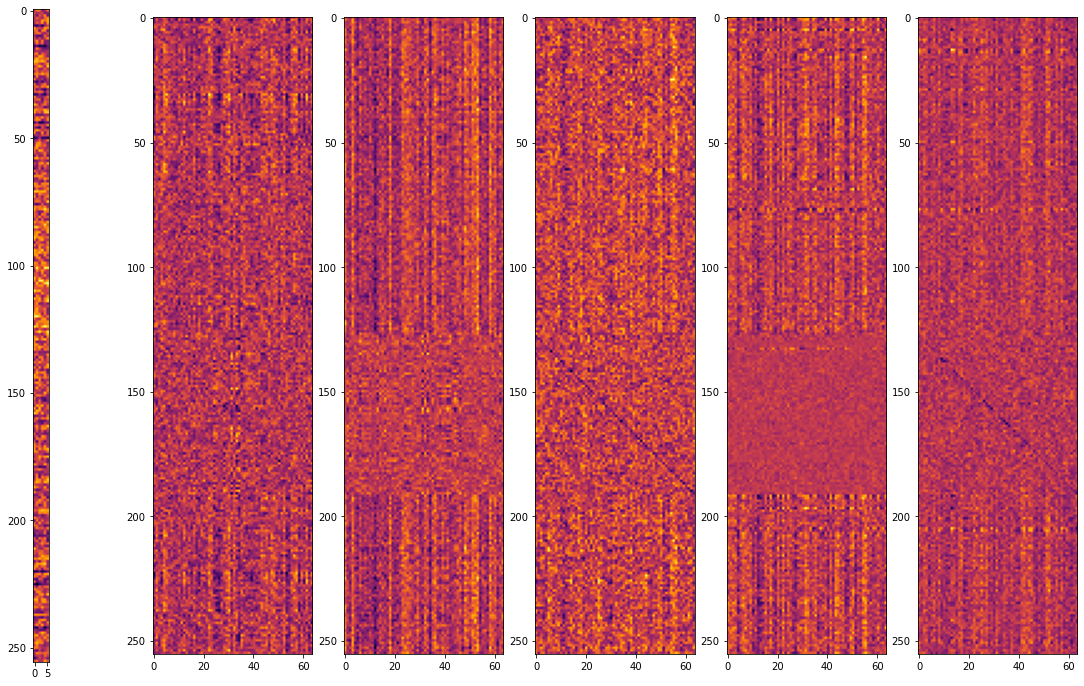

In [30]:
import matplotlib.pyplot as plt
import cv2

# norm_img=cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# plt.imshow(img, cmap='gray')
fig, ax = plt.subplots(1,6,figsize=(20,12))
ax[0].imshow(model.lstm.weight_ih_l0.cpu().detach().numpy(), cmap='inferno')
ax[1].imshow(model.lstm.weight_hh_l0.cpu().detach().numpy(), cmap='inferno')
ax[2].imshow(model.lstm.weight_ih_l1.cpu().detach().numpy(), cmap='inferno')
ax[3].imshow(model.lstm.weight_hh_l1.cpu().detach().numpy(), cmap='inferno')
ax[4].imshow(model.lstm.weight_ih_l2.cpu().detach().numpy(), cmap='inferno')
ax[5].imshow(model.lstm.weight_hh_l2.cpu().detach().numpy(), cmap='inferno')

# ih_l0 - has dimension 6 x 512

# fig.tight_layout()

In [ ]:
# Stock market indices
# assets = ['^GSPC', '^DJI', '^IXIC', '^RUT']

assets = ['SPY', 'DIA', 'ONEQ', 'IWM']

asset_list = assets

In [ ]:
# Iterate through index list, check if we already have the data (load it) or go get it from Yahoo! (save it)
# Make a dictionary of dataframes containing all the data

start_date = '01-01-2005'
# stop_date = '05-01-2018' # First version of paper
stop_date = '12-20-2019' # Final version of paper
directory = '../../../data/yahoo_data'

# If the 'directory' doesn't exist, create it
#if os.path.isdir(directory) == False:
#    os.mkdir(directory)

asset_dict = {}
for asset in asset_list:
    df = get_data(asset_name=asset, directory=directory, start_date=start_date, stop_date=stop_date)    
    asset_dict[asset] = df 

In [ ]:
for asset in asset_list:
    display(asset_dict[asset].head(5))
    print(asset, asset_dict[asset].describe())

In [ ]:
# Plot all the assets in Plotly interactive charts with a Candlestick chart
for asset in asset_list:
    plotly_candlestick(asset_dict, asset)

In [ ]:
# Before we split the data into train, validation and test sets let's add the Prev Adj Close feature and
# remove the Date and Volume columns (which are not used)

for asset in asset_list:
    asset_dict[asset] = add_features_to_df(asset_dict[asset])       
    display(asset, asset_dict[asset].head(5))

In [ ]:
# Define the start and end dates for each of the sets - start and end dates are inclusive

# Training set
train_start = '01-01-2005'
train_end = '01-01-2008'

# Validation set
valid_start = '01-02-2008'
valid_end = '12-31-2009'

# A combined train / valid set
train_val_start = '01-01-2005'
train_val_end = '12-31-2009'

# Pre-test set (120 days prior to test period, to generate allocation policy for testing)
pre_test_start = '07-15-2009'
pre_test_end = '12-31-2009'

# Out of sample test set
test_start = '01-01-2010'
test_end = '12-20-2019'


In [21]:
# paper_baseline = {'SPY':136.4, 'DIA':136.6, 'ONEQ':228.9, 'IWM':163.5} # Original paper
paper_baseline = {'SPY':188.87, 'DIA':172.87, 'ONEQ':293.32, 'IWM':167.34, 'SYN':0} # Latest paper - table 12


train_asset_dict = {}
valid_asset_dict = {}
test_asset_dict = {}
train_val_asset_dict = {}
pre_test_asset_dict = {}

for asset in asset_list:
    # Make a dataframe for this asset
    df = asset_dict[asset]
    
    # Mask off the training data and assign result to a train_asset dictionary
    mask = (df['Date'] >= train_start) & (df['Date'] <= train_end)
    train_asset_dict[asset] = df.loc[mask]
    
    # Mask off the validation data and assign result to a valid_asset dictionary
    mask = (df['Date'] >= valid_start) & (df['Date'] <= valid_end)
    valid_asset_dict[asset] = df.loc[mask]
    
    # Mask off the test data and assign result to a test_asset dictionary
    mask = (df['Date'] >= test_start) & (df['Date'] <= test_end)
    test_asset_dict[asset] = df.loc[mask]
    
    # Mask off the combined train / validation data and assign result to a train_val_asset dictionary
    mask = (df['Date'] >= train_val_start) & (df['Date'] <= train_val_end)
    train_val_asset_dict[asset] = df.loc[mask]

    # Mask off the pre_test data and assign result to a pre_test_asset dictionary
    mask = (df['Date'] >= pre_test_start) & (df['Date'] <= pre_test_end)
    pre_test_asset_dict[asset] = df.loc[mask]
    
    # Reset the indices to start from 0 again for each of the dataframes
    train_asset_dict[asset].index = np.arange(train_asset_dict[asset].shape[0])    
    valid_asset_dict[asset].index = np.arange(valid_asset_dict[asset].shape[0])    
    test_asset_dict[asset].index = np.arange(test_asset_dict[asset].shape[0])
    train_val_asset_dict[asset].index = np.arange(train_val_asset_dict[asset].shape[0])    
    pre_test_asset_dict[asset].index = np.arange(pre_test_asset_dict[asset].shape[0])    

    
#    display(test_asset_dict[asset])

print("Adjusted Close to Adjusted Close:")
print('Asset\tStart Date\t\tBeg$\tEnd Date\t\tEnd$\tGain%\tPaper%')
for asset in asset_list:
    # Print the buy and hold returns over the entire test period (the papers baseline)
    start = test_asset_dict[asset]['Adj Close'].loc[0]
    end = test_asset_dict[asset]['Adj Close'].loc[test_asset_dict[asset].shape[0]-1]
    gain = 100.0 * (end - start) / start
    
    print(asset, '\t', test_asset_dict[asset]['Date'].loc[0], '\t{:1.2f}'.format(start), '\t', 
          test_asset_dict[asset]['Date'].loc[test_asset_dict[asset].shape[0]-1], 
          '\t{:1.2f}'.format(end), '\t{:1.2f}'.format(gain), '\t{:1.2f}'.format(paper_baseline[asset]))

print("\nClose to Close:")
print('Asset\tStart Date\t\tBeg$\tEnd Date\t\tEnd$\tGain%\tPaper%')
for asset in asset_list:
    # Print the buy and hold returns over the entire test period (the papers baseline)
    start = test_asset_dict[asset]['Close'].loc[0]
    end = test_asset_dict[asset]['Close'].loc[test_asset_dict[asset].shape[0]-1]
    gain = 100.0 * (end - start) / start
    
    print(asset, '\t', test_asset_dict[asset]['Date'].loc[0], '\t{:1.2f}'.format(start), '\t', 
          test_asset_dict[asset]['Date'].loc[test_asset_dict[asset].shape[0]-1], 
          '\t{:1.2f}'.format(end), '\t{:1.2f}'.format(gain), '\t{:1.2f}'.format(paper_baseline[asset]))
    
print("\nOpen to Close:")
print('Asset\tStart Date\t\tBeg$\tEnd Date\t\tEnd$\tGain%\tPaper%')
for asset in asset_list:
    # Print the buy and hold returns over the entire test period (the papers baseline)
    start = test_asset_dict[asset]['Open'].loc[0]
    end = test_asset_dict[asset]['Close'].loc[test_asset_dict[asset].shape[0]-1]
    gain = 100.0 * (end - start) / start
    
    print(asset, '\t', test_asset_dict[asset]['Date'].loc[0], '\t{:1.2f}'.format(start), '\t', 
          test_asset_dict[asset]['Date'].loc[test_asset_dict[asset].shape[0]-1], 
          '\t{:1.2f}'.format(end), '\t{:1.2f}'.format(gain), '\t{:1.2f}'.format(paper_baseline[asset]))    
    
# It looks like the paper used Close-Close or Open-Close rather than Adjusted Close to compute gains over the test period. 
# They are a lot closer to the paper quoted returns and better correlated
    

In [ ]:
print("Train set length:", len(train_asset_dict['SPY']))
print("Valid set length", len(valid_asset_dict['SPY']))
print("Train / Valid set length", len(train_val_asset_dict['SPY']))
print("Pre-test set", len(pre_test_asset_dict['SPY']))
print("Test set",len(test_asset_dict['SPY']))